# Example notebook for collecting data, training and evaluating the model

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skfda.ml.clustering import FuzzyCMeans, KMeans


import salishsea_tools.viz_tools as sa_vi

## Files Reading

In [2]:
# The location of the file
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')

# # Downgrading the resolution
# ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
#     y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# Selecting the first 2 years
dataset = ds.sel(time_counter = slice('2007-2-15', '2023-4-30'))
dates = pd.DatetimeIndex(dataset['time_counter'].values)


## Opening the dataset and its features

<xarray.Dataset> Size: 20GB
Dimensions:                 (time_counter: 1279, y: 898, x: 398)
Coordinates:
  * time_counter            (time_counter) datetime64[ns] 10kB 2007-02-15T12:...
  * y                       (y) int64 7kB 0 1 2 3 4 5 ... 893 894 895 896 897
  * x                       (x) int64 3kB 0 1 2 3 4 5 ... 393 394 395 396 397
Data variables:
    Temperature_(0m-15m)    (time_counter, y, x) float32 2GB ...
    Temperature_(15m-100m)  (time_counter, y, x) float32 2GB ...
    Salinity_(0m-15m)       (time_counter, y, x) float32 2GB ...
    Salinity_(15m-100m)     (time_counter, y, x) float32 2GB ...
    Silicon                 (time_counter, y, x) float32 2GB ...
    Nitrate                 (time_counter, y, x) float32 2GB ...
    Ammonium                (time_counter, y, x) float32 2GB ...
    Diatom                  (time_counter, y, x) float32 2GB ...
    Flagellate              (time_counter, y, x) float32 2GB ...
    Microzooplankton        (time_counter, y, x) float32

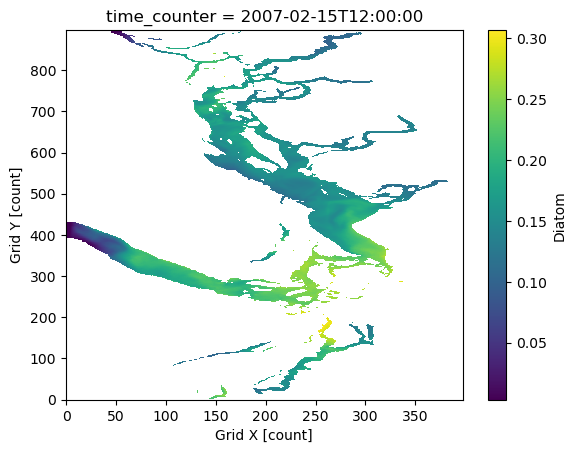

In [3]:
# Printing the features of the dataset
print(dataset)

# Plotting diatoms for the first day
dataset.Diatom[0].plot()

## Datasets Preparation

In [12]:
test = np.reshape(np.ravel(dataset.Flagellate), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(test).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
test = test[:, indx[0]]


In [13]:
from skfda.representation.grid import FDataGrid
test2 = FDataGrid(test.transpose())

## Training 

In [14]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(test2)
clusters = kmeans.predict(test2)
clusters


array([2, 2, 2, ..., 2, 2, 2])

In [15]:
unique, counts = np.unique(clusters, return_counts=True)

In [16]:
indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
indx2[indx[0]] = clusters
clusters = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
clusters= xr.DataArray(clusters,
    coords = {'y': dataset.y, 'x': dataset.x},
    dims = ['y','x'],
    attrs=dict(description="Clusters of the performed self organizing map algorithm",
    long_name ="Cluster",
    units="count"),)

Text(0.5, 1.0, 'Functional Clustering for Flagellates')

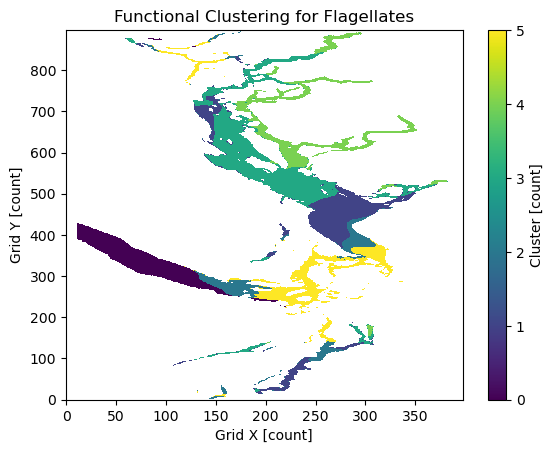

In [20]:
clusters.plot()
plt.title('Functional Clustering for Flagellates')

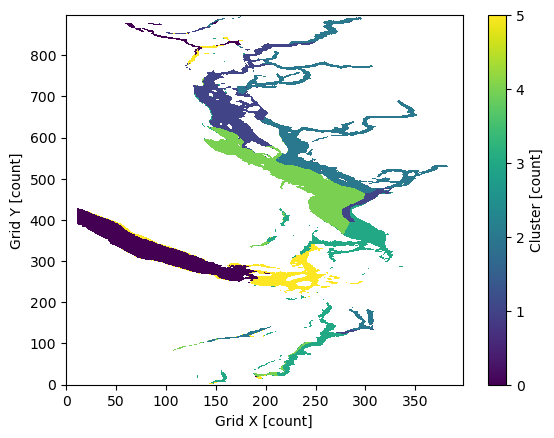

In [11]:
clusters.plot()